### OPTICS → K‑Medoids → GMM

In [1]:
import warnings
warnings.filterwarnings("ignore")


Pipeline 2 (OPTICS → K-Medoids → GMM)
Best silhouette score: 0.9090531854622856
Best OPTICS params: {'min_samples': 17}


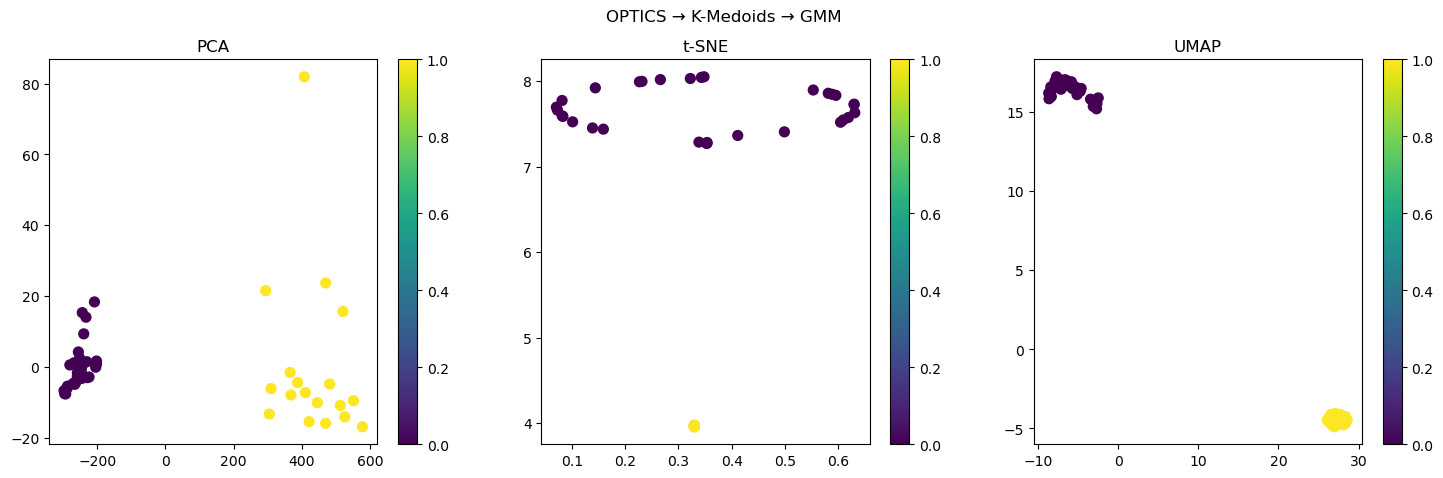

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = (r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv")  # Update this path to your CSV file
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    """
    Runs K-Medoids using pyclustering.
    
    Parameters:
      X           : numpy array of shape (n_samples, n_features)
      n_clusters  : desired number of clusters
      random_state: seed for reproducibility
      
    Returns:
      labels       : numpy array of cluster labels for X
      medoid_coords: numpy array of medoid coordinates used for initialization
    """
    # Convert data to a list-of-lists (pyclustering format)
    data_list = X.tolist()
    n_samples = len(data_list)
    
    # Choose initial medoids randomly using the given random state
    import random
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    
    # Run K-Medoids using pyclustering
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()   # List of clusters (each is a list of indices)
    final_medoids = kmedoids_instance.get_medoids() # Final medoid indices
    
    # Create label array (initialize with -1)
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
            
    # Compute medoid coordinates from final medoid indices
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    # t-SNE reduction
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    # UMAP reduction
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 2: OPTICS → Alternative K-Medoids → GMM
# -------------------------------
def run_pipeline_optics_kmedoids_gmm(X, n_iter=20):
    best_score = -1
    best_params = None
    best_labels = None  # Tuple: (optics_labels, kmed_labels, gmm_labels, mask)
    
    # Random search grid for the OPTICS parameter "min_samples"
    param_grid = {
        'min_samples': list(range(2, 20))
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        # Step 1: OPTICS clustering
        optics_clusterer = OPTICS(min_samples=params['min_samples'])
        optics_labels = optics_clusterer.fit_predict(X)
        
        # Remove noise points (if any, label = -1)
        mask = optics_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(optics_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids refinement on filtered data
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM for probabilistic clustering using medoid centers for initialization
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Evaluate clustering using silhouette score
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = (optics_labels, kmed_labels, gmm_labels, mask)
    
    print("Pipeline 2 (OPTICS → K-Medoids → GMM)")
    print("Best silhouette score:", best_score)
    print("Best OPTICS params:", best_params)
    return best_labels, best_score

if __name__ == "__main__":
    labels_pipe2, score2 = run_pipeline_optics_kmedoids_gmm(X)
    if labels_pipe2 is not None:
        optics_labels, kmed_labels, gmm_labels, mask = labels_pipe2
        visualize_clusters(X[mask], gmm_labels, title="OPTICS → K-Medoids → GMM")


In [6]:
!pip install umap-learn


Pipeline 2 (OPTICS → K-Medoids → GMM) with fixed clusters = 5
Best silhouette score: 0.4638602500430669
Best OPTICS params: {'min_samples': 10}


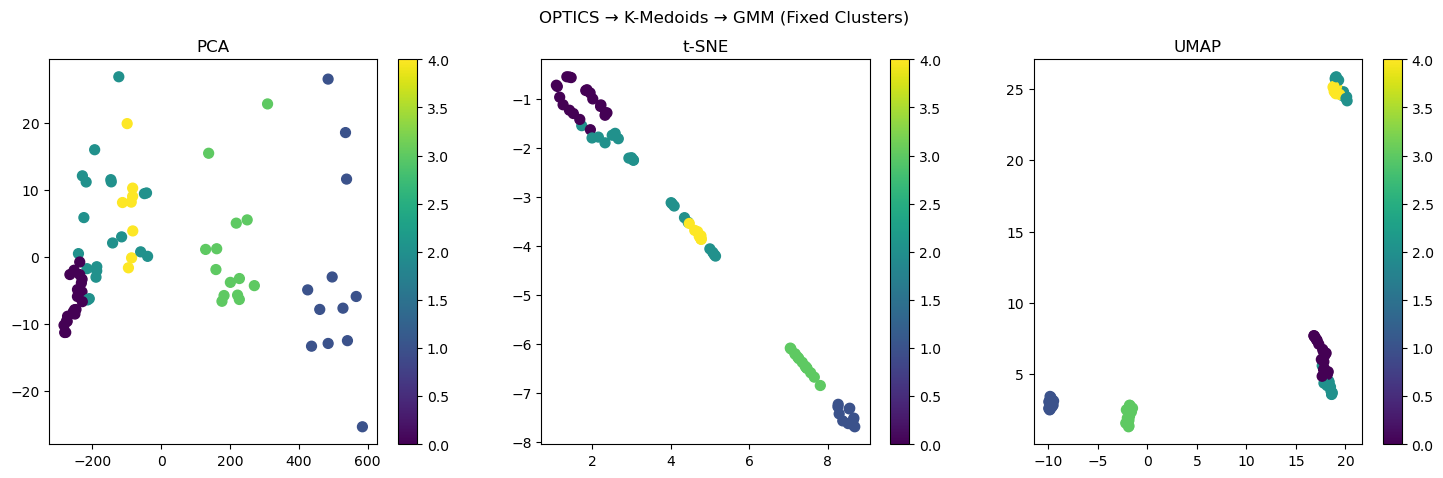

In [8]:
r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.kmedoids import kmedoids
import random

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

def run_pipeline_optics_kmedoids_gmm(X, n_clusters, n_iter=20):
    best_score = -1
    best_labels = None
    param_grid = {'min_samples': list(range(2, 20))}
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        optics_clusterer = OPTICS(min_samples=params['min_samples'])
        optics_labels = optics_clusterer.fit_predict(X)
        mask = optics_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_labels = (optics_labels, kmed_labels, gmm_labels, mask)
    
    return best_labels, best_score

if __name__ == "__main__":
    cluster_range = list(range(2, 11)) + [25]
    scores = {}
    
    for n in cluster_range:
        labels_pipe, score = run_pipeline_optics_kmedoids_gmm(X, n_clusters=n)
        scores[n] = score
        print(f"Clusters: {n}, Silhouette Score: {score}")
    
    print("Final Silhouette Scores:")
    for n, score in scores.items():
        print(f"Clusters: {n}, Score: {score}")


Clusters: 2, Silhouette Score: 0.9090531854622856
Clusters: 3, Silhouette Score: 0.7518288800347344
Clusters: 4, Silhouette Score: 0.6635019981611177
Clusters: 5, Silhouette Score: 0.4638602500430669
Clusters: 6, Silhouette Score: 0.23117911066286448
Clusters: 7, Silhouette Score: 0.06990213366653136
Clusters: 8, Silhouette Score: 0.20188858225258677
Clusters: 9, Silhouette Score: 0.3775500695675431
Clusters: 10, Silhouette Score: 0.27184542823433916
Clusters: 25, Silhouette Score: 0.12852326273116996
Final Silhouette Scores:
Clusters: 2, Score: 0.9090531854622856
Clusters: 3, Score: 0.7518288800347344
Clusters: 4, Score: 0.6635019981611177
Clusters: 5, Score: 0.4638602500430669
Clusters: 6, Score: 0.23117911066286448
Clusters: 7, Score: 0.06990213366653136
Clusters: 8, Score: 0.20188858225258677
Clusters: 9, Score: 0.3775500695675431
Clusters: 10, Score: 0.27184542823433916
Clusters: 25, Score: 0.12852326273116996


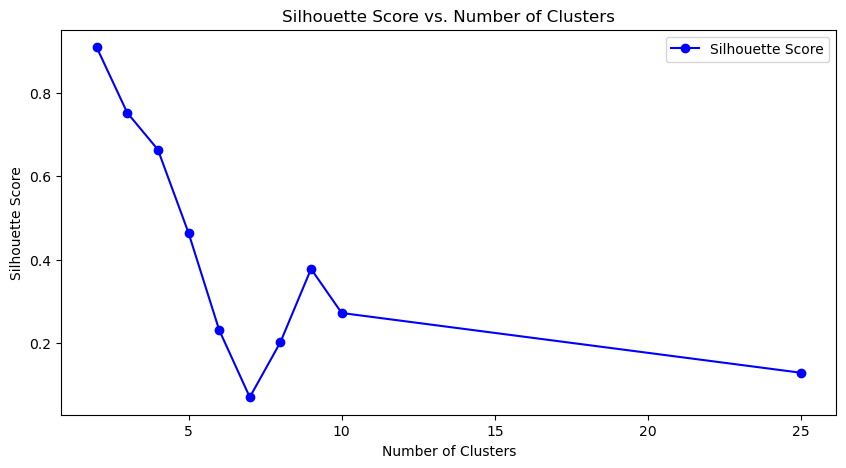

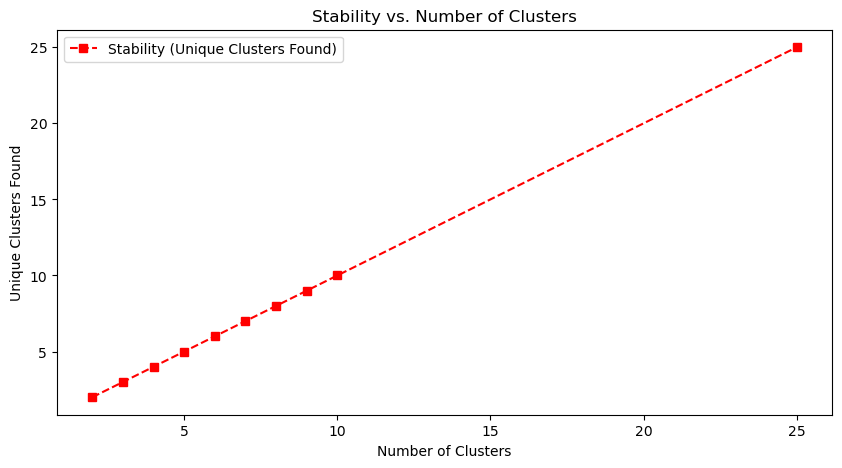

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSV file and preprocess data
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Alternative K-Medoids function
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# Pipeline function
def run_pipeline_optics_kmedoids_gmm(X, fixed_clusters, n_iter=20):
    best_score = -1
    best_labels = None
    param_grid = {'min_samples': list(range(2, 20))}
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        optics_clusterer = OPTICS(min_samples=params['min_samples'])
        optics_labels = optics_clusterer.fit_predict(X)
        
        mask = optics_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, fixed_clusters, random_state)
        
        try:
            gmm = GaussianMixture(n_components=fixed_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_labels = (optics_labels, kmed_labels, gmm_labels, mask)
    
    return best_labels, best_score

# Run for n_clusters = 2 to 10 and 25
clusters_range = list(range(2, 11)) + [25]
silhouette_scores = []
stability_scores = []

for n_clusters in clusters_range:
    labels_pipe2, score2 = run_pipeline_optics_kmedoids_gmm(X, fixed_clusters=n_clusters)
    if labels_pipe2 is not None:
        silhouette_scores.append(score2)
        stability_scores.append(len(set(labels_pipe2[2])))  # Number of unique clusters found
    else:
        silhouette_scores.append(None)
        stability_scores.append(None)

# Plot silhouette score graph
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.show()

# Plot stability graph
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, stability_scores, marker='s', linestyle='--', color='r', label='Stability (Unique Clusters Found)')
plt.xlabel("Number of Clusters")
plt.ylabel("Unique Clusters Found")
plt.title("Stability vs. Number of Clusters")
plt.legend()
plt.show()


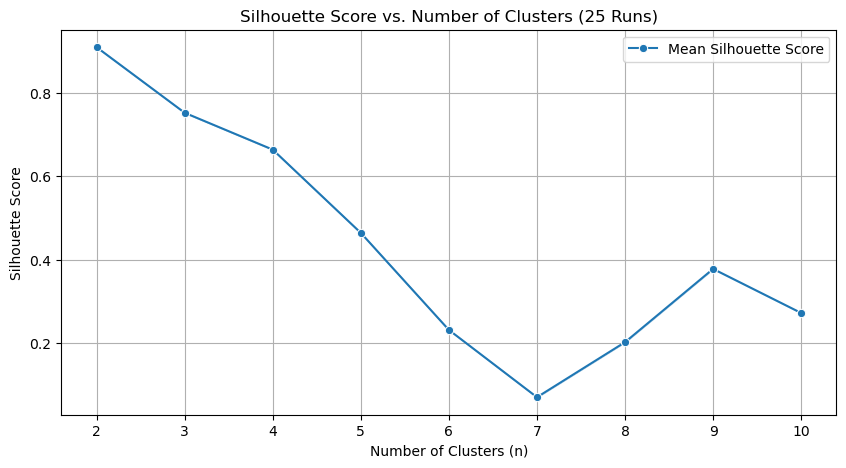

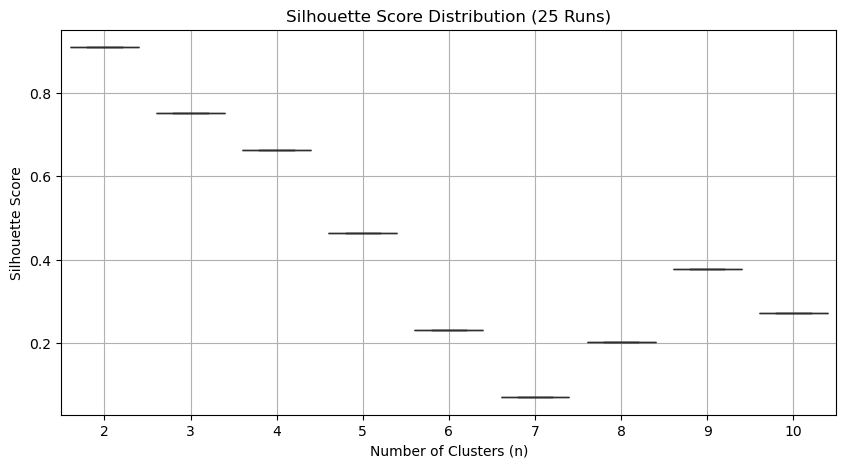

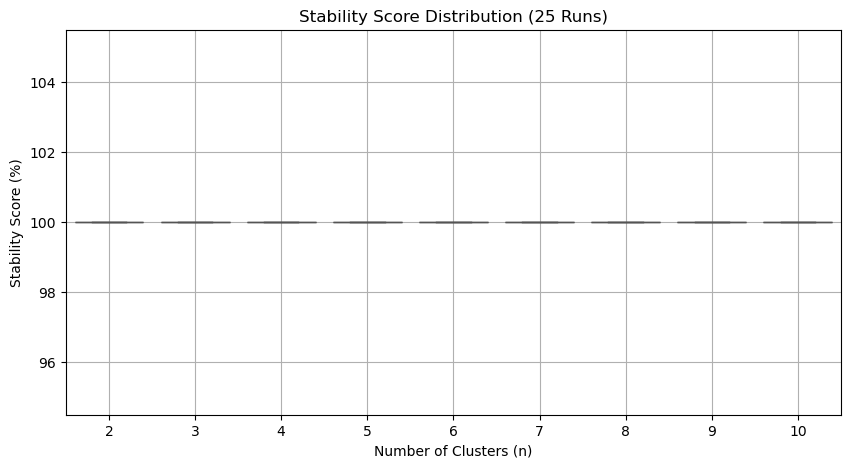

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction libraries (for visualization if needed)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Pipeline: OPTICS → Alternative K-Medoids → GMM
# -------------------------------
def run_pipeline_optics_kmedoids_gmm(X, fixed_clusters, n_iter=20):
    best_score = -1
    best_labels = None  # Tuple: (optics_labels, kmed_labels, gmm_labels, mask)
    param_grid = {'min_samples': list(range(2, 20))}
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        # Step 1: OPTICS clustering
        optics_clusterer = OPTICS(min_samples=params['min_samples'])
        optics_labels = optics_clusterer.fit_predict(X)
        
        # Remove noise points (label = -1)
        mask = optics_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        
        # Use fixed number of clusters
        n_clusters = fixed_clusters
        
        # Step 2: Alternative K-Medoids refinement on filtered data
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM for probabilistic clustering using medoid centers for initialization
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_labels = (optics_labels, kmed_labels, gmm_labels, mask)
    
    return best_labels, best_score

# -------------------------------
# Evaluate Stability and Silhouette Scores over 25 runs for n=2 to 10
# -------------------------------
def evaluate_stability_and_silhouette(X, n_range=(2, 10), runs=25):
    stability_results = {n: [] for n in range(n_range[0], n_range[1] + 1)}
    silhouette_results = {n: [] for n in range(n_range[0], n_range[1] + 1)}
    
    for n_clusters in range(n_range[0], n_range[1] + 1):
        run_labels = []
        run_scores = []
        for _ in range(runs):
            labels_tuple, score = run_pipeline_optics_kmedoids_gmm(X, fixed_clusters=n_clusters)
            if labels_tuple is not None:
                # Use the GMM labels for consistency.
                run_labels.append(labels_tuple[2])
                run_scores.append(score)
        # Save silhouette scores for this n
        if run_scores:
            silhouette_results[n_clusters] = run_scores
        else:
            silhouette_results[n_clusters] = [None]
        
        # Compute stability as the average pairwise percentage agreement across runs.
        # For each pair of runs, compute the fraction of matching labels (up to the minimum length).
        if len(run_labels) > 1:
            pair_agreements = []
            for i in range(len(run_labels)):
                for j in range(i+1, len(run_labels)):
                    min_len = min(len(run_labels[i]), len(run_labels[j]))
                    labels_i = run_labels[i][:min_len]
                    labels_j = run_labels[j][:min_len]
                    agreement = np.mean(labels_i == labels_j)
                    pair_agreements.append(agreement)
            stability = np.mean(pair_agreements) * 100  # Convert to percentage
        else:
            stability = None
        stability_results[n_clusters] = [stability] * len(run_labels) if run_labels else [None]
    
    return stability_results, silhouette_results

stability_scores, silhouette_scores = evaluate_stability_and_silhouette(X, n_range=(2, 10), runs=25)

# Convert results to DataFrames for plotting
stability_df = pd.DataFrame([(n, score) for n, scores in stability_scores.items() for score in scores if score is not None],
                            columns=['Clusters', 'Stability Score (%)'])
silhouette_df = pd.DataFrame([(n, score) for n, scores in silhouette_scores.items() for score in scores if score is not None],
                             columns=['Clusters', 'Silhouette Score'])

# -------------------------------
# Plot Silhouette Score Line Graph
# -------------------------------
plt.figure(figsize=(10, 5))
sns.lineplot(data=silhouette_df, x='Clusters', y='Silhouette Score', marker='o', label='Mean Silhouette Score')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (25 Runs)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# Plot Silhouette Score Boxplot
# -------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=silhouette_df, x='Clusters', y='Silhouette Score', palette='viridis')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Distribution (25 Runs)')
plt.grid(True)
plt.show()

# -------------------------------
# Plot Stability Score Boxplot
# -------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=stability_df, x='Clusters', y='Stability Score (%)', palette='coolwarm')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Stability Score (%)')
plt.title('Stability Score Distribution (25 Runs)')
plt.grid(True)
plt.show()


In [ ]:
r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"

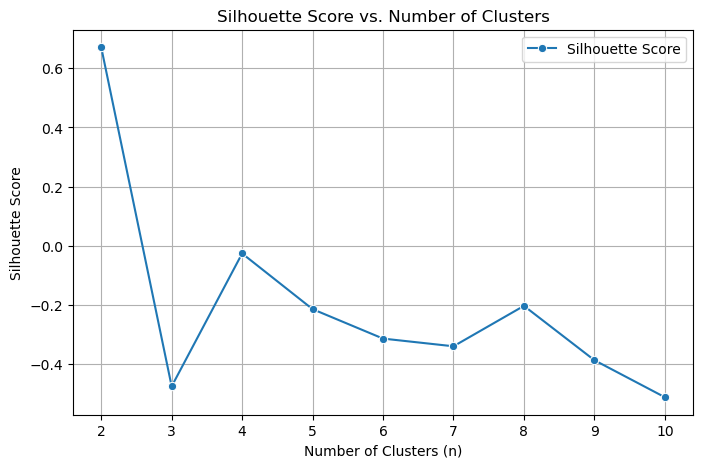

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Clustering libraries
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.kmedoids import kmedoids

import random

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
centroid_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"
image_path = "restored_white_background_debug-Copy1.png"

df = pd.read_csv(csv_filename)
centroid_df = pd.read_csv(centroid_csv)

# Drop unnecessary columns
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
if "Nucleus Present" in centroid_df.columns:
    centroid_df = centroid_df.drop("Nucleus Present", axis=1)

X = df.values
X_centroids = centroid_df[['X Centroid', 'Y Centroid']].values

# Load original Nissl-stained image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Pipeline: OPTICS → Alternative K-Medoids → GMM
# -------------------------------
def run_pipeline_optics_kmedoids_gmm(X, fixed_clusters):
    optics_clusterer = OPTICS(min_samples=5)
    optics_labels = optics_clusterer.fit_predict(X)

    # Remove noise points (label = -1)
    mask = optics_labels != -1
    if np.sum(mask) < 2:
        return None, None
    X_filtered = X[mask]

    # Step 2: Alternative K-Medoids
    kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, fixed_clusters, random_state)

    # Step 3: GMM
    try:
        gmm = GaussianMixture(n_components=fixed_clusters, means_init=medoid_coords, random_state=random_state)
        gmm.fit(X_filtered)
        gmm_labels = gmm.predict(X_filtered)
    except Exception:
        return None, None

    try:
        score = silhouette_score(X_filtered, gmm_labels)
    except Exception:
        score = -1

    return gmm_labels, score

# -------------------------------
# Generate images and silhouette scores for n=2 to 10
# -------------------------------
silhouette_scores = {}

for n_clusters in range(2, 11):
    cluster_labels, score = run_pipeline_optics_kmedoids_gmm(X, n_clusters)
    
    if cluster_labels is None:
        continue

    silhouette_scores[n_clusters] = score

    # Fix length mismatch by padding missing labels with -1
    if len(cluster_labels) < len(X_centroids):
        padding = np.full((X_centroids.shape[0] - len(cluster_labels),), -1)
        cluster_labels = np.concatenate([cluster_labels, padding])

    # Scatter plot of clusters
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(X_centroids[:, 0], X_centroids[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"Scatter Plot of Clusters (n={n_clusters})")
    plt.xlabel("X Centroid")
    plt.ylabel("Y Centroid")
    plt.savefig(f"scatter_n{n_clusters}.png")
    plt.close()

    # Contour overlay on original image
    contour_image = original_image.copy()
    for i in range(len(X_centroids)):
        x, y = int(X_centroids[i, 0]), int(X_centroids[i, 1])
        cluster_id = cluster_labels[i]
        color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color per cluster
        cv2.circle(contour_image, (x, y), 5, color, -1)

    plt.figure(figsize=(6, 6))
    plt.imshow(contour_image)
    plt.title(f"Contour Overlay (n={n_clusters})")
    plt.axis('off')
    plt.savefig(f"contour_n{n_clusters}.png")
    plt.close()

# -------------------------------
# Save silhouette scores
# -------------------------------
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=["Clusters", "Silhouette Score"])
silhouette_df.to_csv("silhouette_scores.csv", index=False)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
sns.lineplot(data=silhouette_df, x='Clusters', y='Silhouette Score', marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.savefig("silhouette_scores.png")
plt.show()


In [35]:
print("X_centroids shape:", X_centroids.shape)
print("Cluster labels shape:", cluster_labels.shape)



X_centroids shape: (121, 2)
Cluster labels shape: (73,)


In [7]:
print("X_centroids shape:", X_centroids.shape)
print("cluster_labels shape:", cluster_labels.shape)
print("Length mismatch:", X_centroids.shape[0] != cluster_labels.shape[0])


X_centroids shape: (121, 2)
cluster_labels shape: (73,)
Length mismatch: True


In [48]:
df = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv")
print(df.columns)


Index(['Cell Number', 'Cell Type', 'Area', 'Perimeter', 'Major Axis Length',
       'Minor Axis Length', 'Soma Diameter', 'Aspect Ratio', 'Circularity',
       'Solidity', 'Nucleolus Present', 'X Centroid', 'Y Centroid'],
      dtype='object')


In [9]:

print("X_centroids shape:", X_centroids.shape)  # Should be (121, 2)
print("cluster_labels shape:", cluster_labels.shape)  # Should be (121,)
print("Are there missing labels?", len(cluster_labels) < len(X_centroids))


X_centroids shape: (121, 2)
cluster_labels shape: (73,)
Are there missing labels? True


In [17]:
print(f"X_centroids shape: {X_centroids.shape}")
print(f"Cluster labels shape: {cluster_labels.shape}")


X_centroids shape: (121, 2)
Cluster labels shape: (73,)
